DATA CLEANING

In [137]:
# Python version 3.10.9 
# import necessary libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
import optuna

In [138]:
# load the data and inspect head
df = pd.read_csv('income_case_study.csv',delimiter=';')

# inspect the head of the data
df.head()

,age,workclass,education_level,education-num,marital-status,Name,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,17.0,Private,11th,7.0,Never-married,Karen,Sales,Own-child,White,Female,0,0,24,United-States,NaN
1,18.0,Private,12th,8.0,Never-married,Karen,Machine-op-inspct,Own-child,White,Male,0,0,30,United-States,NaN
2,18.0,Private,Some-college,10.0,Never-married,Karen,Other-service,Own-child,White,Female,0,0,20,United-States,NaN
3,19.0,Private,Some-college,10.0,Never-married,Billie,Adm-clerical,Own-child,White,Male,0,0,30,United-States,NaN
4,21.0,Private,Some-college,10.0,Never-married,Audrey,Other-service,Not-in-family,White,Female,0,0,35,United-States,NaN


In [139]:
# inspect missing values
df.isnull().sum()

age                 529
workclass             0
education_level     537
education-num      3533
marital-status        0
Name                  0
occupation            0
relationship          0
race                  0
sex                   0
capital-gain          0
capital-loss          0
hours-per-week        0
native-country        0
income             5559
dtype: int64

In [140]:
# generate a mapper to fill missing values in both education_level and education_num columns and remove nan value
unique_num = df.sort_values('education-num')['education-num'].unique()
unique_level = df.sort_values('education-num')['education_level'].unique()

#remove nan value in both unique_num and unique_level
unique_num = unique_num[~np.isnan(unique_num)]
unique_level = unique_level[~pd.isnull(unique_level)]

# fill missing values in education_level column
df['education_level'] = df['education_level'].fillna(df['education-num'].map(dict(zip(unique_num,unique_level))))

# fill missing values in education_num column
df['education-num'] = df['education-num'].fillna(df['education_level'].map(dict(zip(unique_level,unique_num))))

In [141]:
# group by education_level, occupation, and relationship to calculate the median age
median_ages = df.groupby(['education_level', 'occupation', 'relationship'])['age'].median().reset_index()

# fill missing values in age column
for index, row in df.iterrows():
    if pd.isnull(row['age']):
        age = median_ages[(median_ages['education_level'] == row['education_level']) & (median_ages['occupation'] == row['occupation']) & (median_ages['relationship'] == row['relationship'])]['age']
        if len(age) > 0:
            df.at[index, 'age'] = age.values[0]

In [142]:
df.isnull().sum()

age                   1
workclass             0
education_level       0
education-num         0
marital-status        0
Name                  0
occupation            0
relationship          0
race                  0
sex                   0
capital-gain          0
capital-loss          0
hours-per-week        0
native-country        0
income             5559
dtype: int64

In [143]:
# drop rows with missing values
df = df.dropna()

FEATURE EXPLORATION

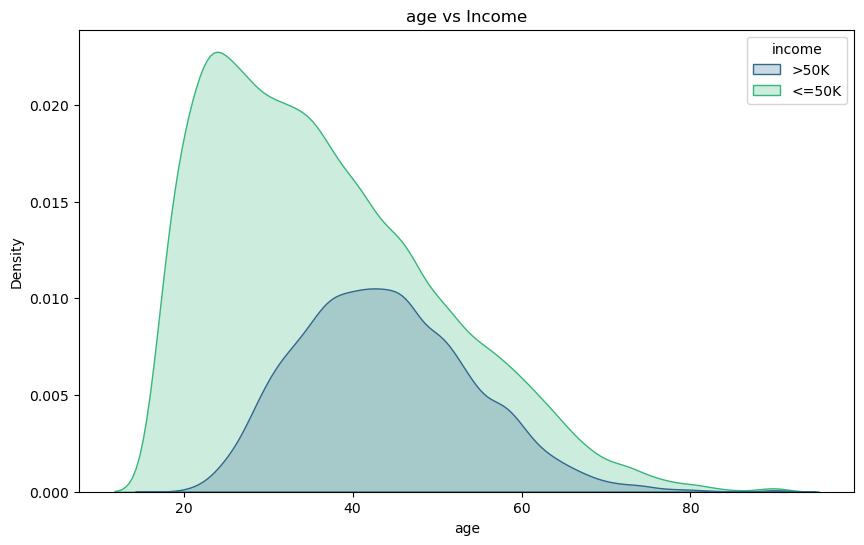

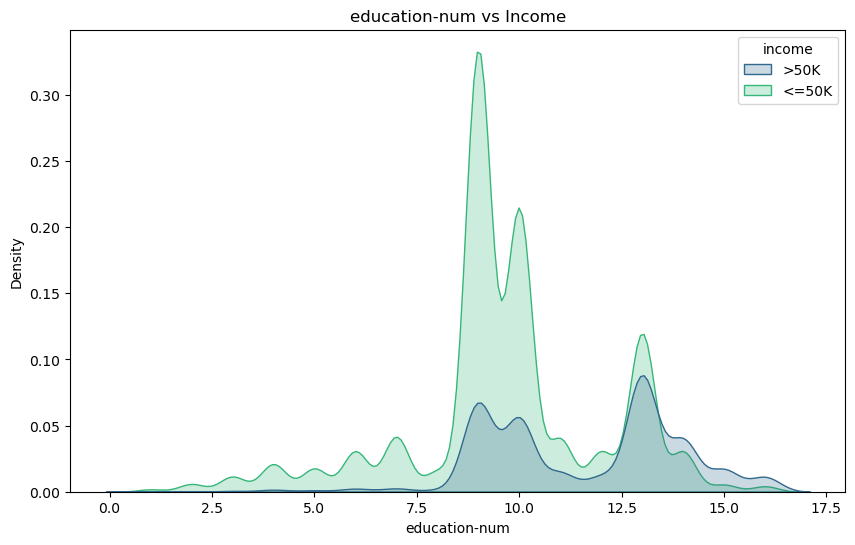

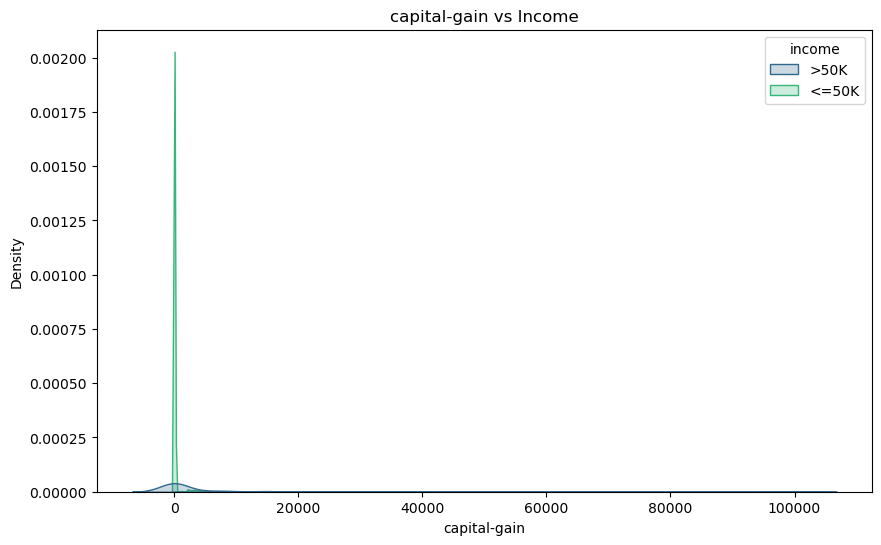

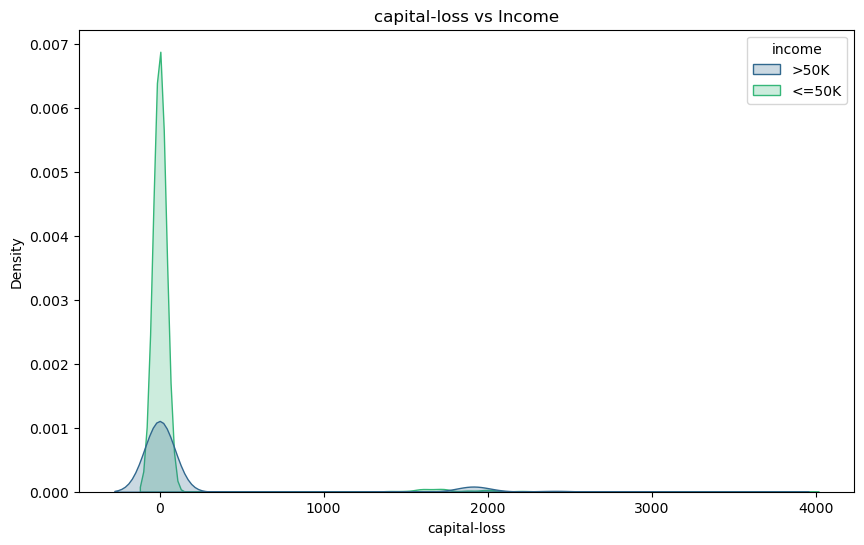

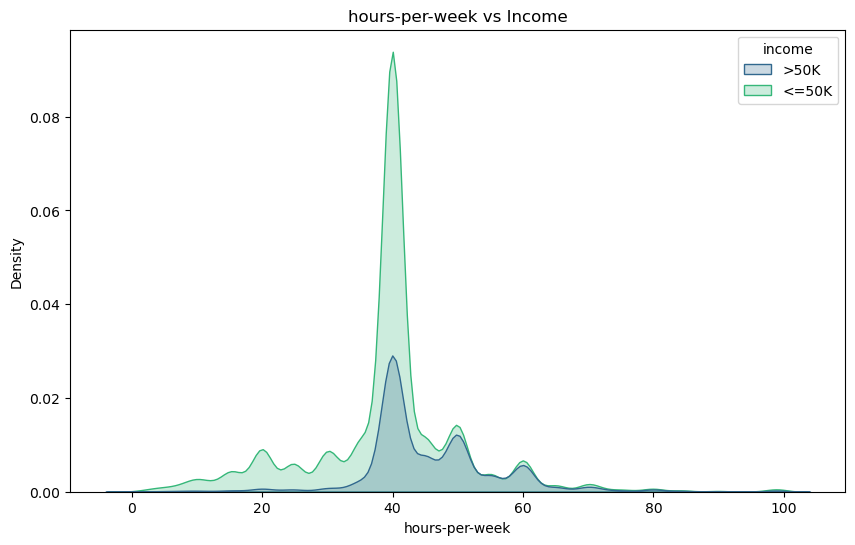

In [144]:
numerical_columns = df.select_dtypes(include=[np.number]).columns

# density plot for numerical columns
for col in numerical_columns:
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data=df, x=col, hue='income', fill=True, palette='viridis')
    plt.title(f'{col} vs Income')
    plt.show()

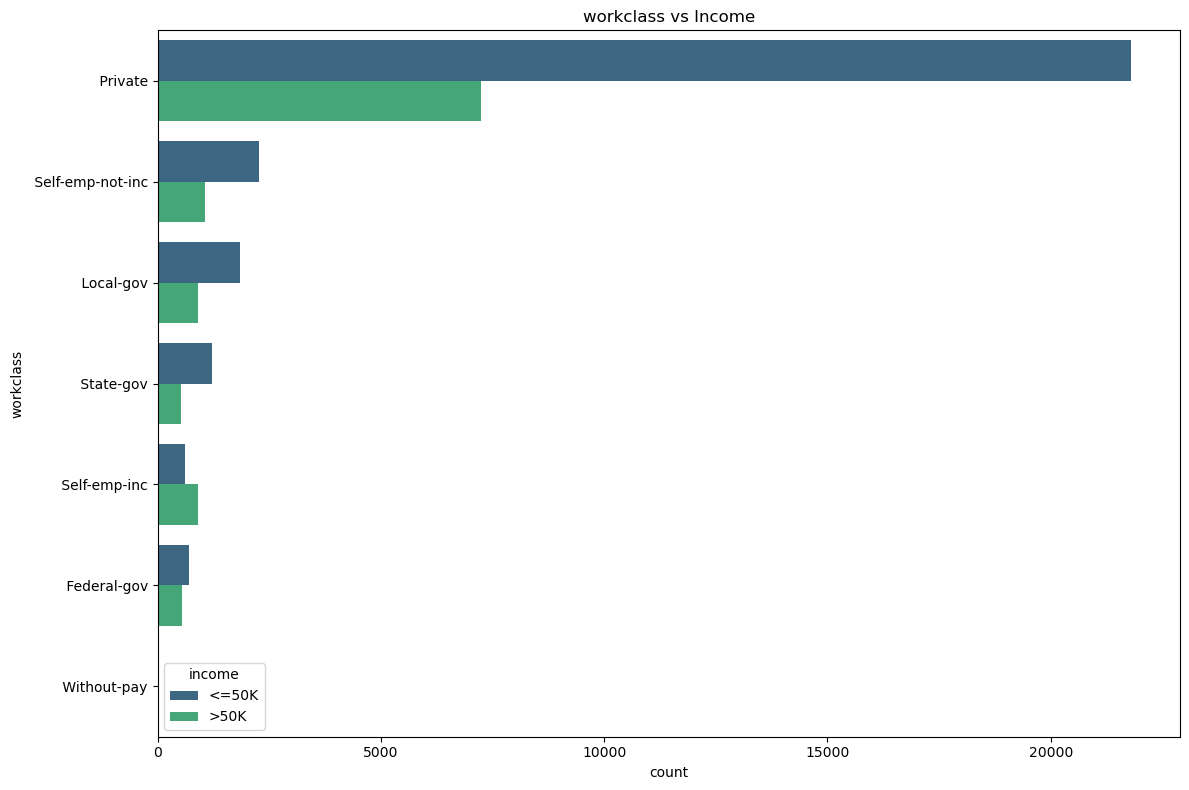

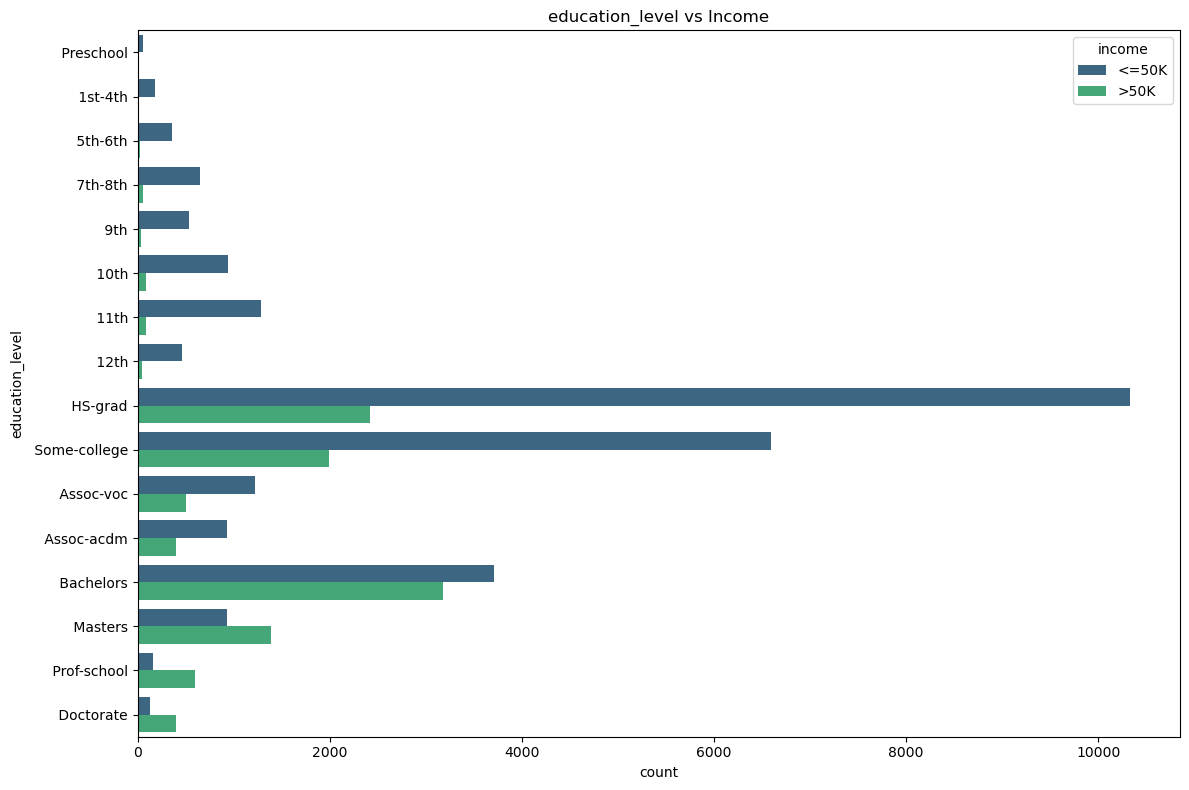

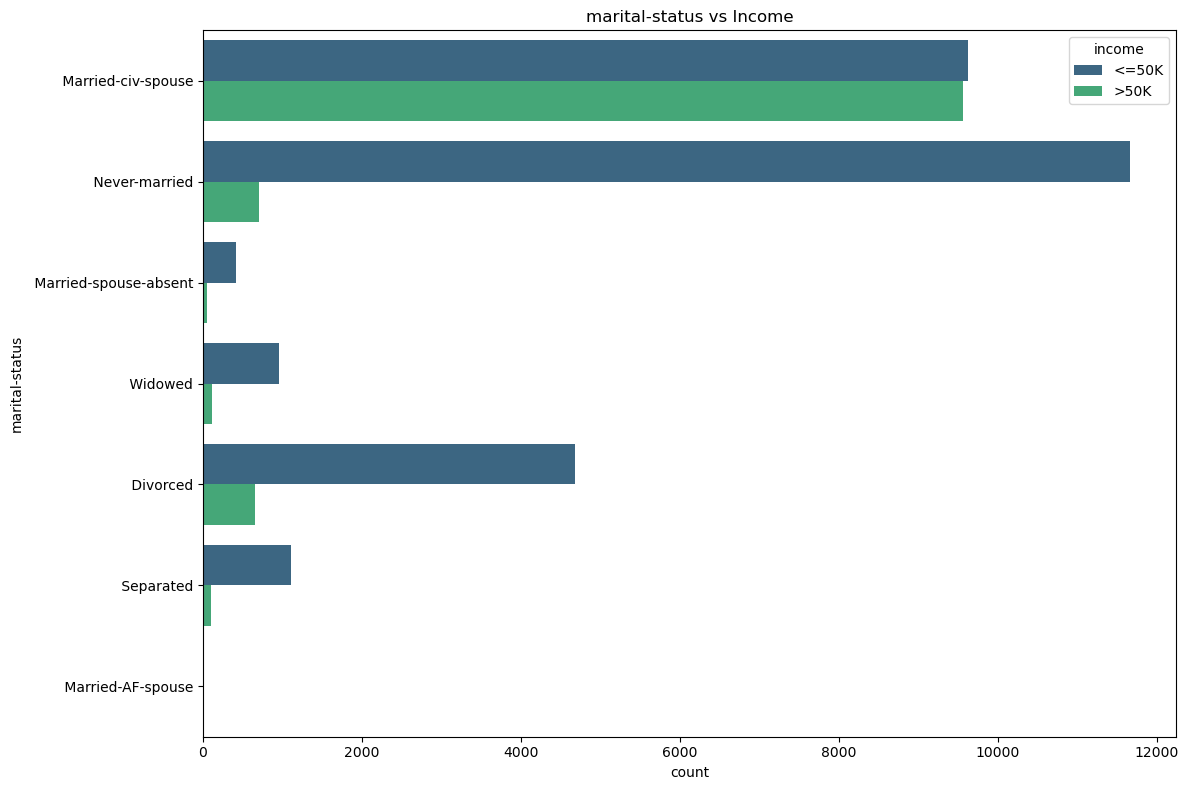

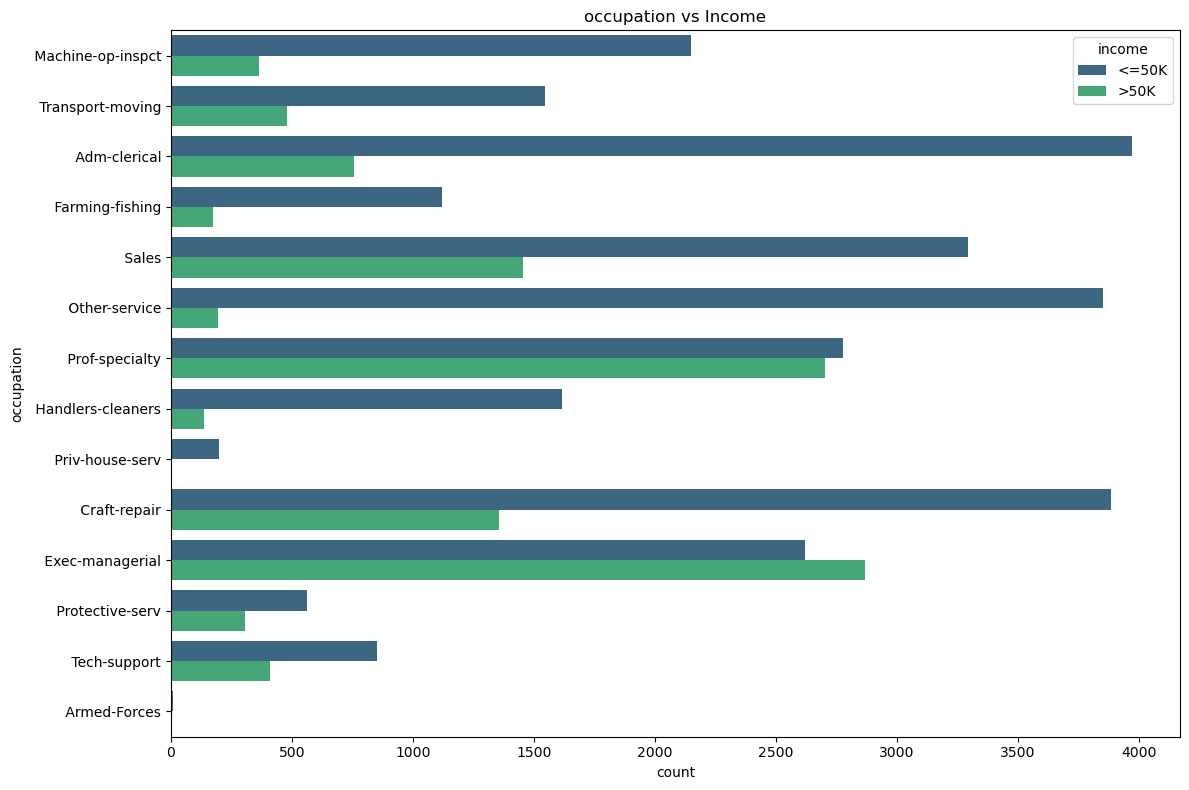

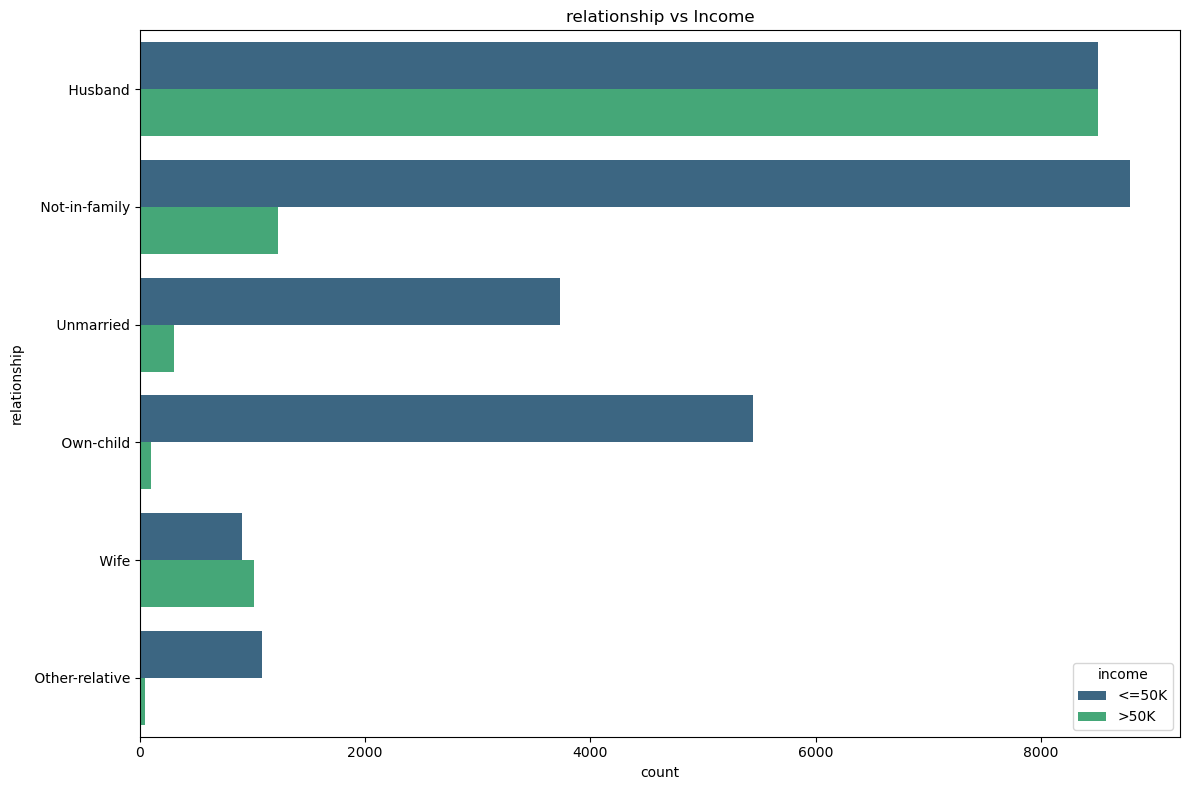

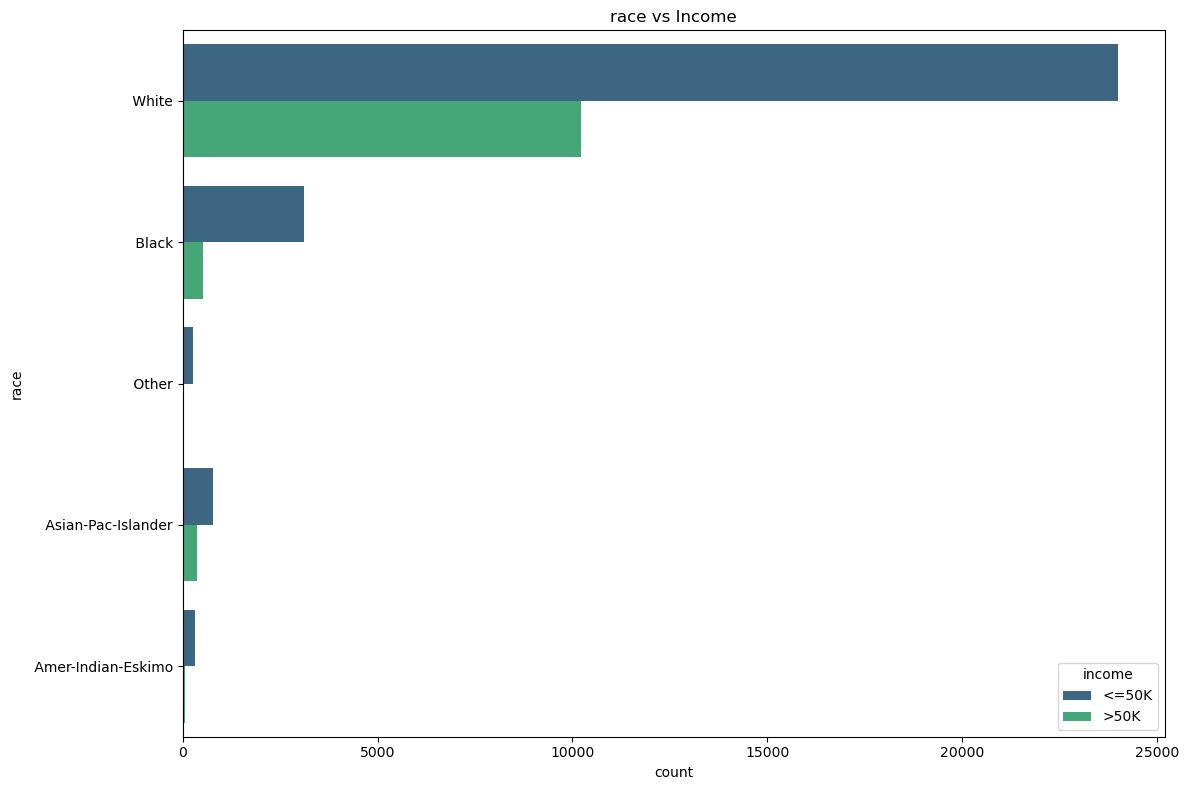

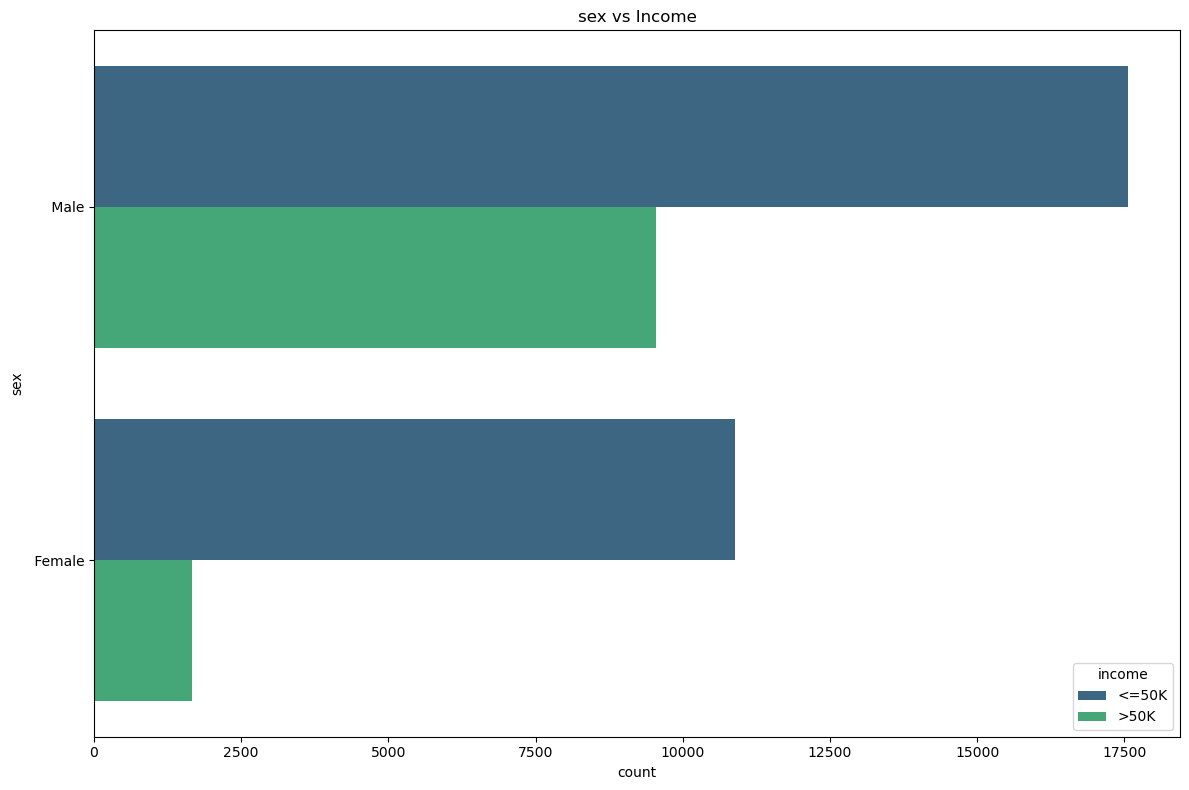

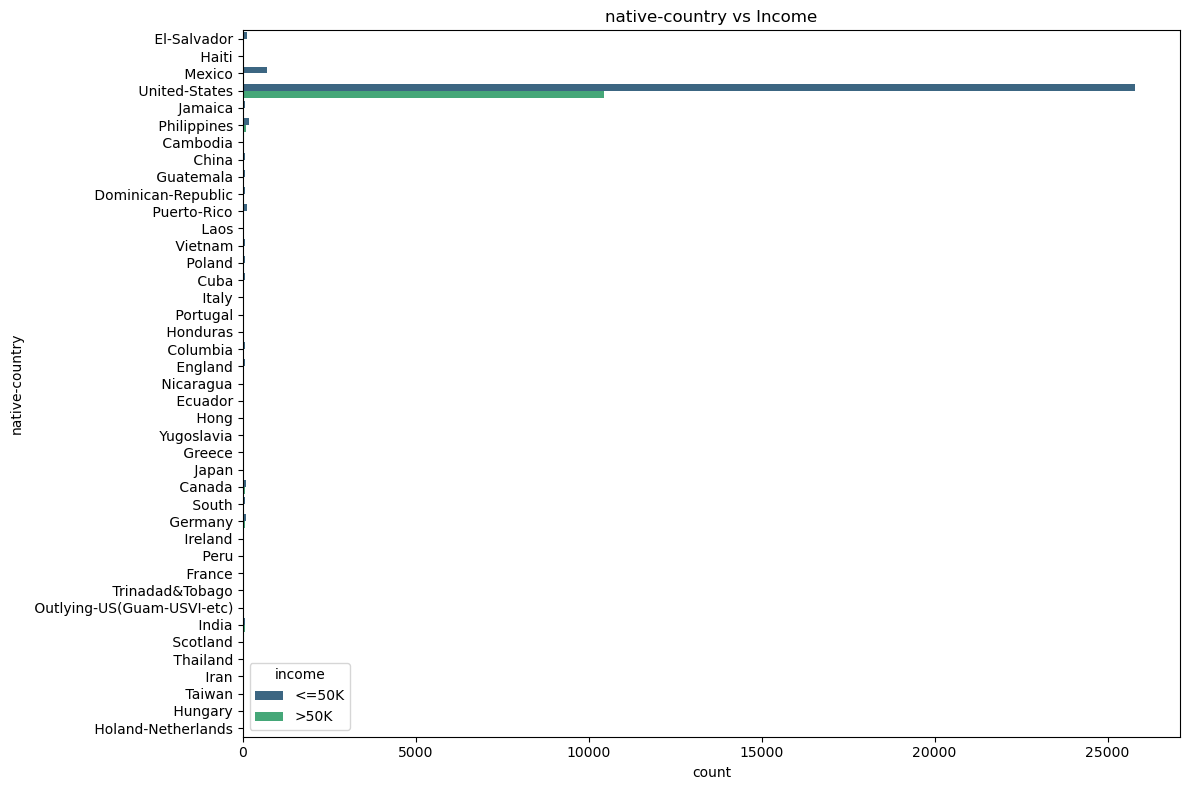

In [145]:
categorical_columns = list(df.select_dtypes(include=['object']).columns)
# count plots for categorical features
for col in categorical_columns:
    if col == 'income' or col == 'Name':
        continue
    plt.figure(figsize=(12, 8))
    count_plot = sns.countplot(y=col, hue='income', data=df.sort_values('education-num'), orient='h', palette='viridis')
    plt.title(f'{col} vs Income')
    plt.tight_layout()
    plt.show()    

DATA PREPROCESSING

In [146]:
# drop irrelevant columns
df = df.drop(['Name', 'education_level','native-country'], axis=1)

# standard scaling for numerical columns
scaler = MinMaxScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

# encode categorical variables
label_encoders = {}
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# split the data into features and target variable
X = df.drop('income', axis=1)
y = df['income']

MODEL SELECTION AND HYPERPARAMETER OPTIMIZATION

In [147]:
class HyperParameterOptimization:
    # initialize the class with the data, metric, and number of trials
    def __init__(self, X, y, metric, n_trials):
        self.X = X
        self.y = y
        self.metric = metric
        self.n_trials = n_trials

    # define the objective functions for each model
    def DTC_objective(self, trial):
        max_depth = trial.suggest_int('max_depth', 10, 25)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

        model = DecisionTreeClassifier(
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=3
        )

        return self.evaluate_model(model)

    def RFC_objective(self, trial):
        n_estimators = trial.suggest_int('n_estimators', 50, 200)
        max_depth = trial.suggest_int('max_depth', 10, 30)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

        model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=3
        )

        return self.evaluate_model(model)

    def LRG_objective(self, trial):
        C = trial.suggest_float('C', 1e-4, 1e4, log=True)
        max_iter = trial.suggest_int('max_iter', 1000, 10000)
        solver = trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'])

        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('log_reg', LogisticRegression(
                C=C,
                max_iter=max_iter,
                solver=solver,
                random_state=3
            ))
        ])

        return self.evaluate_model(pipeline)

    def GBC_objective(self, trial):
        n_estimators = trial.suggest_int('n_estimators', 50, 200)
        max_depth = trial.suggest_int('max_depth', 10, 30)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True)

        model = GradientBoostingClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            learning_rate=learning_rate,
            random_state=3
        )

        return self.evaluate_model(model)

    # evaluate the model using cross-validation
    def evaluate_model(self, model):
        kf = KFold(n_splits=5, shuffle=True, random_state=3)
        cv_scores = cross_val_score(model, self.X, self.y, cv=kf, scoring=self.metric)
        return cv_scores.mean()

    # optimize the models and return the best trials for each model
    def optimize(self):
        studies = {
            "RFC": optuna.create_study(direction='maximize'),
            "LRG": optuna.create_study(direction='maximize'),
            "DTC": optuna.create_study(direction='maximize'),
            "GBC": optuna.create_study(direction='maximize')
        }

        objectives = {
            "RFC": self.RFC_objective,
            "LRG": self.LRG_objective,
            "DTC": self.DTC_objective,
            "GBC": self.GBC_objective
        }

        for key, study in studies.items():
            study.optimize(objectives[key], n_trials=self.n_trials)

        best_trials = {key: study.best_trial for key, study in studies.items()}
        return best_trials


In [148]:
metrics = ['accuracy', 'f1'] # 'accuracy', 'precision', 'recall', 'f1'

# optimize hyperparameters for each metric and log to json file
best_trials = {}
for metric in metrics:
    optimizer = HyperParameterOptimization(X, y, metric, 10)
    best_trial_for_every_model = optimizer.optimize()
    best_trials[metric] = best_trial_for_every_model
    

[I 2024-07-03 15:23:42,587] A new study created in memory with name: no-name-83c296d0-811f-47f9-b3fa-e941eed671eb
[I 2024-07-03 15:23:42,589] A new study created in memory with name: no-name-ff0452af-e9e1-4284-b3f6-97b9bcfceae6
[I 2024-07-03 15:23:42,590] A new study created in memory with name: no-name-9f5cdd14-3a30-4bb4-894f-cc20190f5560
[I 2024-07-03 15:23:42,590] A new study created in memory with name: no-name-7f205819-ab84-45b9-8ac0-3242942c89f0
[I 2024-07-03 15:23:51,820] Trial 0 finished with value: 0.8515204080263992 and parameters: {'n_estimators': 173, 'max_depth': 12, 'min_samples_split': 6, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8515204080263992.
[I 2024-07-03 15:24:04,484] Trial 1 finished with value: 0.8518229608167596 and parameters: {'n_estimators': 198, 'max_depth': 29, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.8518229608167596.
[I 2024-07-03 15:24:12,501] Trial 2 finished with value: 0.8516968828512672 and parameters

In [149]:
print(
    "Best accuracy for Random Forest Classification:" ,best_trials['accuracy']['RFC'].value,
    "\n",
    "Best accuracy for Logistic Regression:" ,best_trials['accuracy']['LRG'].value,
    "\n",
    "Best accuracy for Decision Tree Classification:" ,best_trials['accuracy']['DTC'].value,
    "\n",
    "Best accuracy for Gradient Boosting Classifier:" ,best_trials['accuracy']['GBC'].value,
    "\n"
    "Best f1 score for Random Forest Classification:" ,best_trials['f1']['RFC'].value,
    "\n",
    "Best f1 score for Logistic Regression:" ,best_trials['f1']['LRG'].value,
    "\n",
    "Best f1 score for Decision Tree Classification:" ,best_trials['f1']['DTC'].value,
    "\n",
    "Best f1 score for Gradient Boosting Classifier:" ,best_trials['f1']['GBC'].value
)

Best accuracy for Random Forest Classification: 0.8536887379864865 
 Best accuracy for Logistic Regression: 0.8058847264651339 
 Best accuracy for Decision Tree Classification: 0.843200034657376 
 Best accuracy for Gradient Boosting Classifier: 0.8550754049023406 
Best f1 score for Random Forest Classification: 0.7191009291765375 
 Best f1 score for Logistic Regression: 0.5968181715799749 
 Best f1 score for Decision Tree Classification: 0.7065955366360734 
 Best f1 score for Gradient Boosting Classifier: 0.7253031397237379


EVALUATION AND CONCLUSION

In [155]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

# train the models with the best hyperparameters
model = GradientBoostingClassifier()
model.set_params(**best_trials['accuracy']['GBC'].params)

model.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.011538721105925537, max_depth=10,
                           min_samples_leaf=8, min_samples_split=6,
                           n_estimators=172)

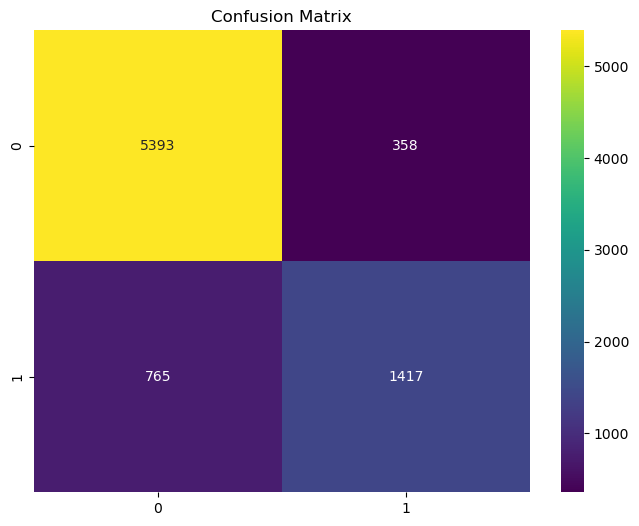

In [156]:
# confusion matrix
y_pred = model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis')
plt.title('Confusion Matrix')
plt.show()

In [157]:
# classification report
class_report = classification_report(y_test, y_pred)

print(class_report)

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      5751
           1       0.80      0.65      0.72      2182

    accuracy                           0.86      7933
   macro avg       0.84      0.79      0.81      7933
weighted avg       0.85      0.86      0.85      7933



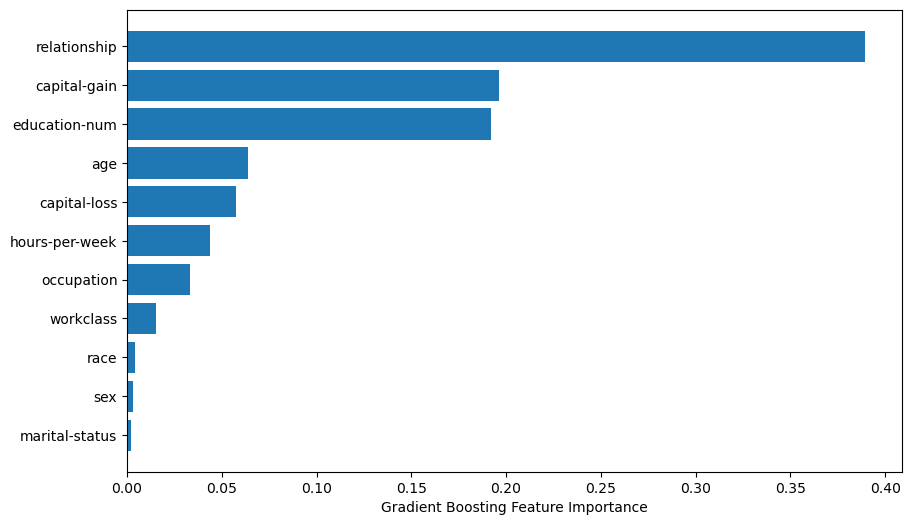

In [159]:
#feature importance

feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)

plt.figure(figsize=(10, 6))
plt.barh(X.columns[sorted_idx], feature_importance[sorted_idx])
plt.xlabel("Gradient Boosting Feature Importance")
plt.show()